<a href="https://colab.research.google.com/github/gusibi/oneplus/blob/master/segment_anyting_with_grounding_dion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 初始化环境

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Tue May  2 16:18:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

# 2. Install requirement

In [ ]:
# install requirement
!pip install gradio segment-anything opencv-python pycocotools matplotlib onnxruntime onnx
!rm -rf GroundingDINO
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO
!pip install -q .
%cd /content

# download sam model
!apt install aria2
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -d /content/models/sam -o sam_vit_h_4b8939.pth
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth -d /content/models/grounding-dino -o groundingdino_swint_ogc.pth


In [ ]:
# !rm -rf GroundingDINO
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO
!pip install -q .
%cd /content

/content/GroundingDINO
  Preparing metadata (setup.py) ... done
/content


# 3. segment Anything

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor,SamAutomaticMaskGenerator, sam_model_registry


sam_checkpoint = "/content/models/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"


sam = sam_model_registry[model_type](sam_checkpoint)
sam.to(device=device)

image = cv2.imread('/content/drive/MyDrive/IMG_3589.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_generator = SamAutomaticMaskGenerator(sam)

"""
To generate masks, just run generate on an image.
Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

segmentation : the mask
area : the area of the mask in pixels
bbox : the boundary box of the mask in XYWH format
predicted_iou : the model's own prediction for the quality of the mask
point_coords : the sampled input point that generated this mask
stability_score : an additional measure of mask quality
crop_box : the crop of the image used to generate this mask in XYWH format
"""
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

error: ignored

# 4. Grounded-Segment-Anything

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


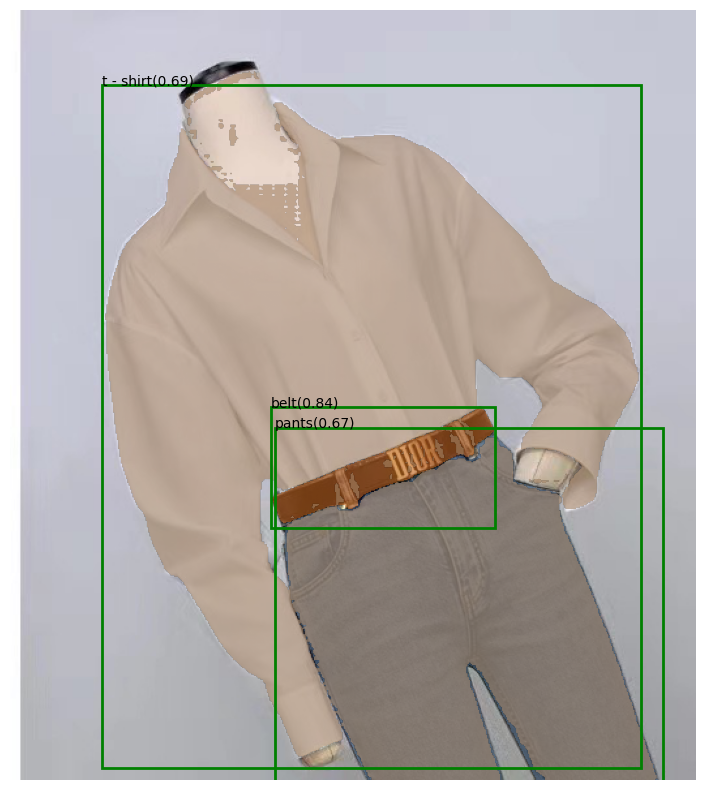

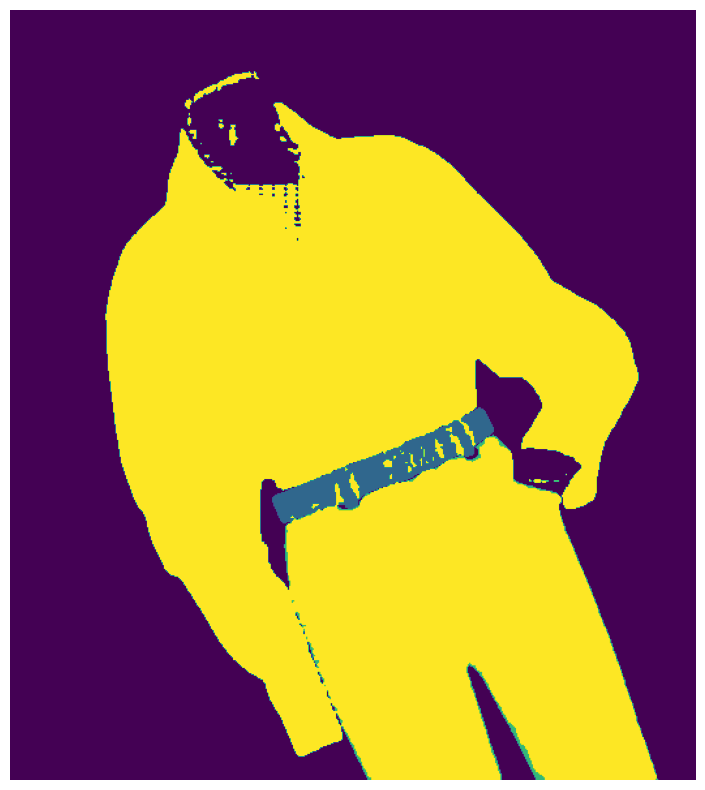

In [ ]:
# Grounded-Segment-Anything
"""
https://github.com/facebookresearch/segment-anything

Install Segment Anything:

    pip install git+https://github.com/facebookresearch/segment-anything.git

## Getting Started
First download a model checkpoint. Then the model can be used in just a few lines to get masks from a given prompt:

default or vit_h: ViT-H SAM model. https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
vit_l: ViT-L SAM model. https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
vit_b: ViT-B SAM model. https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
"""


import os
import io
import json
import base64
import hashlib
from io import BytesIO

import numpy as np
import torch
from PIL import Image

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T

from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import (
    clean_state_dict,
    get_phrases_from_posmap,
)

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


def get_image_md5(img_base64):
    # decode the base64-encoded string to binary data
    data = base64.b64decode(img_base64)

    # compute the MD5 hash of the binary data
    md5_hash = hashlib.md5(data).hexdigest()
    return md5_hash


def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def load_image_from_base64(img_base64):
    # decode the base64-encoded image data to binary data
    img_data = base64.b64decode(img_base64)
    # create a BytesIO object for the binary image data
    img_buffer = BytesIO(img_data)
    # open the image from the BytesIO object
    image_pil = Image.open(img_buffer).convert("RGB")
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def image2base64(image_path):
    # load the image from file
    img = Image.open(image_path).convert("RGB")
    # create a BytesIO object to hold the image data
    buffer = io.BytesIO()
    # write the image data to the buffer in PNG format
    img.save(buffer, format="PNG")
    # encode the binary data in the buffer as a base64-encoded string
    img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return img_base64


def img_base64_to_cv2image(img_base64):
    # decode the base64-encoded image data to binary data
    img_data = base64.b64decode(img_base64)

    # decode the binary image data into a NumPy array
    img_array = np.frombuffer(img_data, dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(
        clean_state_dict(checkpoint["model"]), strict=False
    )
    print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(
    model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"
):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(
            logit > text_threshold, tokenized, tokenlizer
        )
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )
    ax.text(x0, y0, label)


def save_mask_data(image_name, output_dir, mask_list, box_list, label_list):
    value = 0  # 0 for background

    mask_img = torch.zeros(mask_list.shape[-2:])
    for idx, mask in enumerate(mask_list):
        mask_img[mask.cpu().numpy()[0] == True] = value + idx + 1
    plt.figure(figsize=(10, 10))
    plt.imshow(mask_img.numpy())
    plt.axis("off")
    plt.savefig(
        os.path.join(output_dir, f"{image_name}_mask.jpg"),
        bbox_inches="tight",
        dpi=300,
        pad_inches=0.0,
    )

    json_data = [{"value": value, "label": "background"}]
    for label, box in zip(label_list, box_list):
        value += 1
        name, logit = label.split("(")
        logit = logit[:-1]  # the last is ')'
        json_data.append(
            {
                "value": value,
                "label": name,
                "logit": float(logit),
                "box": box.numpy().tolist(),
            }
        )
    with open(os.path.join(output_dir, f"{image_name}_mask.json"), "w") as f:
        json.dump(json_data, f)


output_dir = "/content/drive/MyDrive/AI/output/sam"
grounded_checkpoint = "/content/models/grounding-dino/groundingdino_swint_ogc.pth"
sam_checkpoint = "/content/models/sam/sam_vit_h_4b8939.pth"
config_file = "/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
device = "cuda"


def masking_image_with_img_base64(
    image_base64,
    text_prompt,
    box_threshold=0.3,
    text_threshold=0.25,
    config_file=config_file,
):
    # make dir
    os.makedirs(output_dir, exist_ok=True)
    # load image
    image_pil, image = load_image_from_base64(image_base64)

    raw_img_md5 = get_image_md5(image_base64)
    # visualize raw image
    image_pil.save(os.path.join(output_dir, f"{raw_img_md5}_raw.jpg"))

    # load model
    model = load_model(config_file, grounded_checkpoint, device=device)

    # run grounding dino model
    boxes_filt, pred_phrases = get_grounding_output(
        model, image, text_prompt, box_threshold, text_threshold, device=device
    )

    # initialize SAM
    predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))
    image = img_base64_to_cv2image(image_base64)
    predictor.set_image(image)

    size = image_pil.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    transformed_boxes = predictor.transform.apply_boxes_torch(
        boxes_filt, image.shape[:2]
    ).to(device)

    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes.to(device),
        multimask_output=False,
    )

    # draw output image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
    for box, label in zip(boxes_filt, pred_phrases):
        show_box(box.numpy(), plt.gca(), label)

    plt.axis("off")
    plt.savefig(
        os.path.join(output_dir, f"{raw_img_md5}_grounded_sam_output.jpg"),
        bbox_inches="tight",
        dpi=300,
        pad_inches=0.0,
    )
    save_mask_data(raw_img_md5, output_dir, masks, boxes_filt, pred_phrases)


def masking_image_with_img_path(
    image_path,
    text_prompt,
    box_threshold=0.3,
    text_threshold=0.25,
    config_file=config_file,
):
    image_base64 = image2base64(image_path)
    return masking_image_with_img_base64(
        image_base64,
        text_prompt=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        config_file=config_file,
    )


image_path = "/content/drive/MyDrive/cloth_model.JPG"
text_prompt = "coat. bag. hat. t-shirt. shoes. pants. dress. belt."
masking_image_with_img_path(image_path, text_prompt)


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


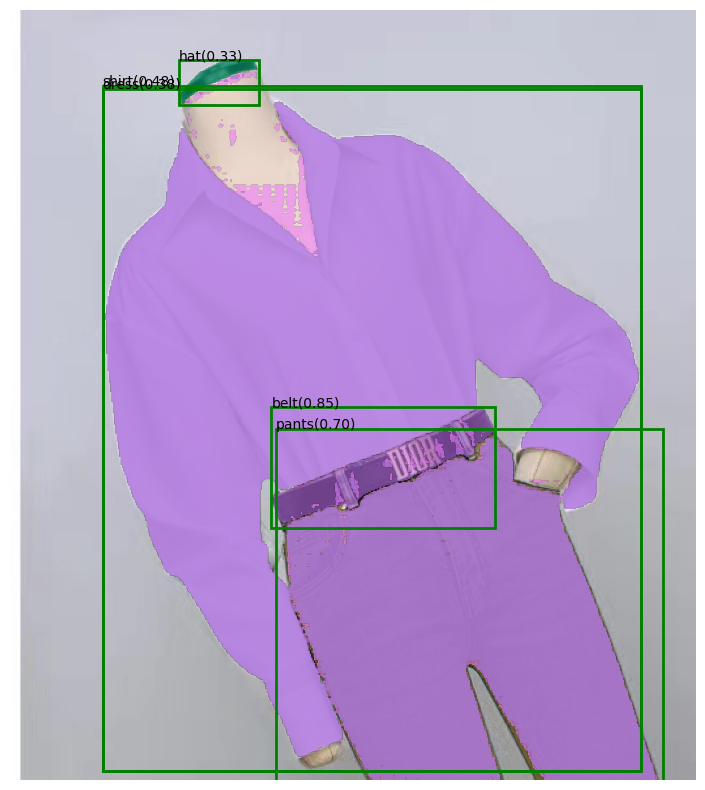

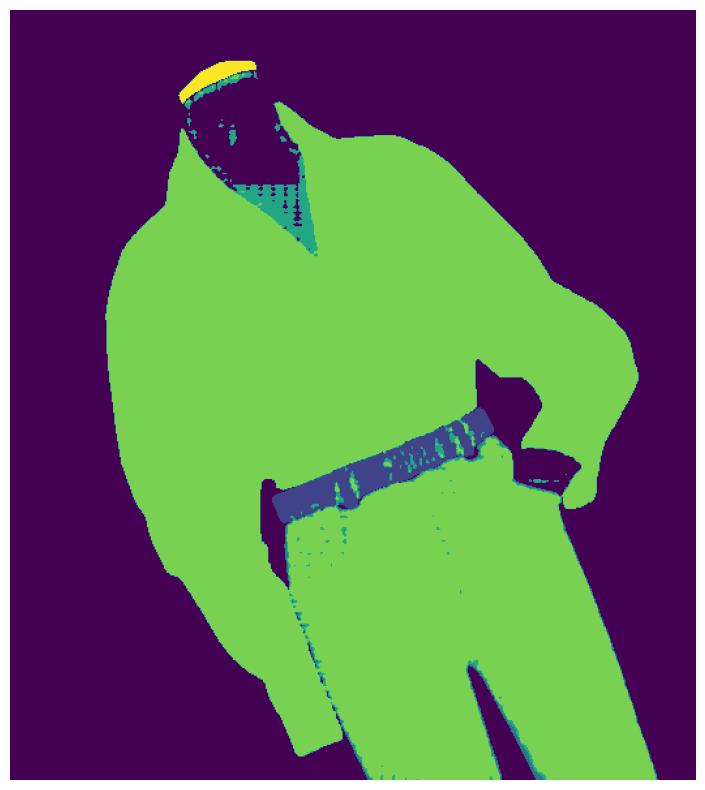

In [ ]:
image_path = "/content/drive/MyDrive/cloth_model.JPG"
text_prompt = "coat. bag. hat. shirt. shoes. pants. dress. belt."
masking_image_with_img_path(image_path, text_prompt)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


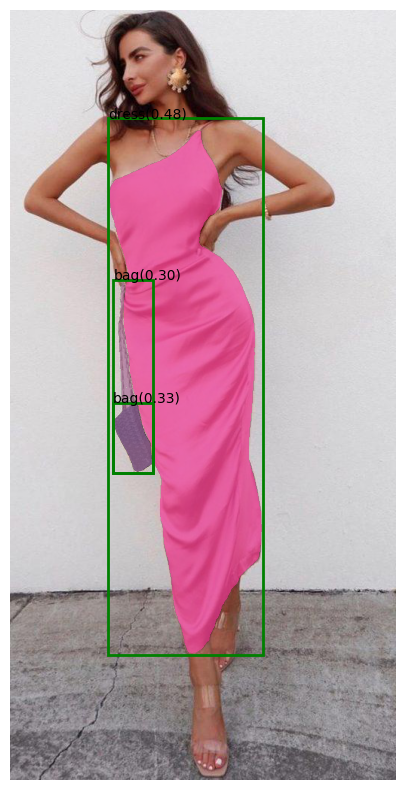

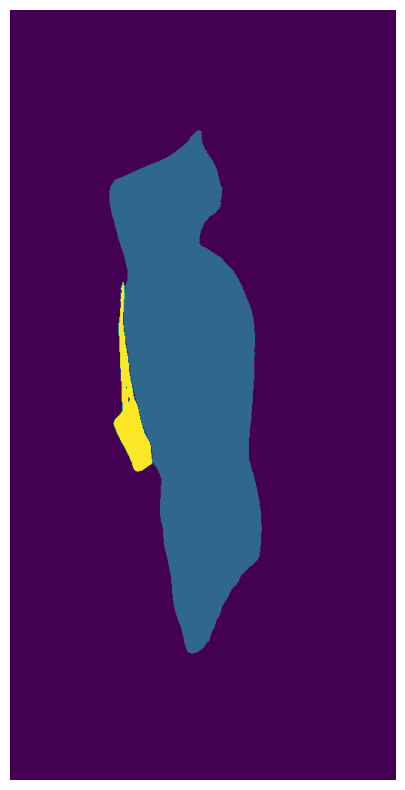

In [ ]:
image_path = "/content/drive/MyDrive/beach-wedding-guest-dresses-tea-length-pink-satin-summer-sexy-petalandpup-512x1024.jpg"
text_prompt = "coat. bag. hat. t-shirt. shoes. pants. dress."
# text_prompt = "face"
masking_image_with_img_path(image_path, text_prompt, box_threshold=0.3, text_threshold=0.25)